In [23]:
import sys
print(sys.version) #파이썬 버전

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [171]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from sklearn.preprocessing import LabelEncoder

import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
import h5py 
import numpy as np
import pandas as pd
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import joblib

# Image Input and Check
### 이미지 input 및 확인

In [107]:
os.getcwd()
filename = input('filename: ')
image = cv2.imread(filename) #이미지 읽기
#g = 0.5
out = image.copy()
#out = out.astype(np.float)
#out = ((out/255)**(1/g))*255
#out = out.astype(np.int)
out = cv2.cvtColor(out,cv2.COLOR_BGR2RGB)
image_resize = cv2.resize(image,(64,64)) #64x64 size


filename: ex4.png


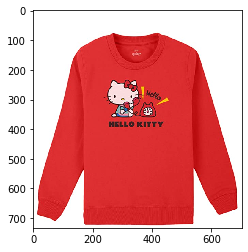

In [108]:
plt.imshow(out)
plt.show()

# Model1. Color Detection

In [163]:
# image RGB로 읽기
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [164]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [187]:
# resize and get colors
def resize(image):
    modified = cv2.resize(image,(600,400),interpolation = cv2.INTER_AREA)
    modified = modified.reshape(modified.shape[0]*modified.shape[1],3)
    return modified

def color(modified,num_colors):
    clf = KMeans(n_clusters = num_colors)
    labels = clf.fit_predict(modified)
    counts = Counter(labels)
    
    center_colors = clf.cluster_centers_
    
    ordered_colors = [center_colors[i] for i in counts.keys() ]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    plt.figure(figsize=(8,6))
    plt.pie(counts.values(),labels = hex_colors, colors = hex_colors)
    
    col_list = list(counts.values())
    
    return hex_colors


['#fefcfc', '#d72a2c', '#58272a']


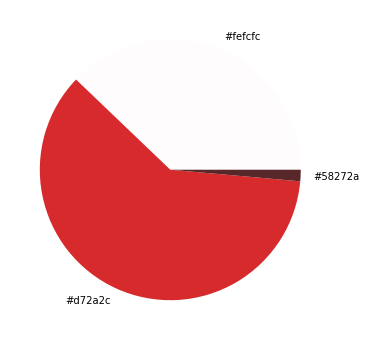

In [188]:
#model1.색상 파악

image = get_image(filename)
modified = resize(image)
print(color(modified, 3))

#우리 db에  hex_colors 저장하는 코드 추가
#self-feedback: 조명에 따라 달라지는 색 보정


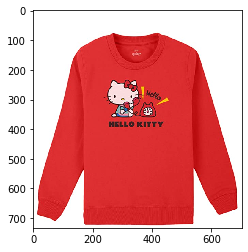

In [217]:
plt.imshow(get_image(filename))

# Model2. Stain detection

훈련데이터: 
https://www.kaggle.com/belkhirnacim/textiledefectdetection?select=matchingtDATASET_test_32.h5 



In [2]:
filename1 = 'matchingtDATASET_train_64.h5'
filename2 = 'matchingtDATASET_test_64.h5'



In [3]:
f = h5py.File(filename1,'r')
keys = list(f.keys())
keys
ex1 = f['color']['angle0'][0]
ex1


array([[[0.26398593, 0.24168451, 0.22224696, ..., 0.15636006,
         0.17018022, 0.18385147],
        [0.27360946, 0.26038352, 0.24402745, ..., 0.18188444,
         0.19547713, 0.20432273],
        [0.29857227, 0.28462866, 0.26602337, ..., 0.20792633,
         0.20974927, 0.22001386],
        ...,
        [0.35321817, 0.32759726, 0.3475035 , ..., 0.44088823,
         0.4794296 , 0.49812785],
        [0.3495055 , 0.31729066, 0.30633613, ..., 0.41806808,
         0.46972   , 0.49847463],
        [0.35340828, 0.3152116 , 0.28266102, ..., 0.3988702 ,
         0.45744514, 0.50874645]]], dtype=float32)

In [4]:
# dataset 만들기
def get_data(filename):
    f = h5py.File(filename,'r')
    keys = list(f.keys())
    a_group_key = list(f.keys())[0]
    angles = list(f[a_group_key])
    image_dict = {}
    for i in keys:
        image_dict[i] = []
        for j in angles:
            image_dict[i].append(f[i][j])
    return image_dict, keys

def raw_data(image_dict,keys):
    labels = []
    image_list = []
    for i in keys:
        for j in image_dict[i]:
            for k in range(0,len(j)):
                labels.append(i)
                image_data = np.squeeze(j[k],axis=0)
                image_list.append(image_data)
    images = np.array(image_list).astype(np.float)
    
    labels = np.array(labels)
    encoder = LabelEncoder()
    encoder.fit(labels)
    real_labels = encoder.transform(labels)
    # encoder.classes_: 0,1,2,3,4,5가 어떤 순서로 matching 되는지
    return images, real_labels, encoder.classes_
                
            
        

In [5]:
f = h5py.File(filename1,'r')
keys = list(f.keys())
a_group_key = list(f.keys())[0]
angles = list(f[a_group_key])
angles

['angle0',
 'angle100',
 'angle120',
 'angle140',
 'angle20',
 'angle40',
 'angle60',
 'angle80']

In [5]:
dat1, keys1 = get_data(filename1)
dat2, keys2 = get_data(filename2)
raw_train_images, train_labels, encoder1 = raw_data(dat1,keys1)
raw_test_images, test_labels, encoder2 = raw_data(dat2,keys2)

5 thread


{0, 1, 2, 3, 4, 5}

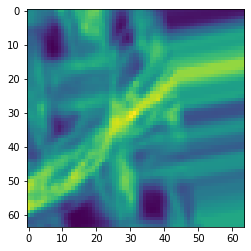

In [402]:
# 사진 예시 확인
raw_train_images[0].shape
plt.subplot()
plt.imshow(raw_train_images[71999])
raw_train_images.shape
print(train_labels[71999],encoder1[train_labels[71999]])
set(train_labels)

In [7]:
#데이터 augmentation generator (rotation, rescale은 제외, 이미 되어 있음)
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1)

In [190]:
# model2. stain detection
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(6,activation='softmax')])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_check = ModelCheckpoint('the_best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

#compile model
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['acc'])




In [18]:
# train model
training_images = np.expand_dims(raw_train_images,axis=-1)
testing_images = np.expand_dims(raw_test_images,axis=-1)


In [20]:
training_images.shape
#y_train = tf.keras.utils.to_categorical(train_labels, num_classes=6)
#y_test =  tf.keras.utils.to_categorical(test_labels, num_classes=6)
test_labels.shape
testing_images.shape

train_generator = train_datagen.flow(training_images,train_labels,batch_size=20)
test_generator = validation_datagen.flow(testing_images,test_labels,batch_size=20)

In [53]:
history = model.fit_generator(train_generator, validation_data=test_generator,
                              steps_per_epoch = 72000//20,
                              epochs=20,
                              validation_steps=36000//20,
                              verbose=2,
                              callbacks=[early_stop, model_check])

model.save('my_model.h5')

Epoch 1/20

Epoch 00001: val_acc did not improve from 0.48378
3600/3600 - 512s - loss: 0.7829 - acc: 0.6876 - val_loss: 2.0359 - val_acc: 0.4571
Epoch 2/20

Epoch 00002: val_acc improved from 0.48378 to 0.57933, saving model to the_best_model.h5
3600/3600 - 513s - loss: 0.7306 - acc: 0.7078 - val_loss: 1.3695 - val_acc: 0.5793
Epoch 3/20

Epoch 00003: val_acc did not improve from 0.57933
3600/3600 - 524s - loss: 0.7066 - acc: 0.7179 - val_loss: 1.7234 - val_acc: 0.5329
Epoch 4/20

Epoch 00004: val_acc did not improve from 0.57933
3600/3600 - 549s - loss: 0.7043 - acc: 0.7199 - val_loss: 1.4404 - val_acc: 0.5658
Epoch 5/20

Epoch 00005: val_acc did not improve from 0.57933
3600/3600 - 545s - loss: 0.7108 - acc: 0.7188 - val_loss: 1.4778 - val_acc: 0.5682
Epoch 6/20

Epoch 00006: val_acc did not improve from 0.57933
3600/3600 - 512s - loss: 0.7285 - acc: 0.7170 - val_loss: 1.8273 - val_acc: 0.5716
Epoch 7/20

Epoch 00007: val_acc did not improve from 0.57933
3600/3600 - 543s - loss: 0.74

In [54]:
model.evaluate(testing_images, test_labels, verbose=0)

[1.4193804264068604, 0.5746666789054871]

In [154]:
new_model = load_model('the_best_model.h5')

In [160]:
# 이미지 전처리 for 모델 삽입
data_height = 64
data_width = 64
channel_n=1

image_stain = cv2.imread(filename)
image_stain = cv2.cvtColor(image_stain, cv2.COLOR_BGR2GRAY)/255
image_stain = cv2.resize(image_stain,(data_height,data_width))
image_stain = np.expand_dims(image_stain,-1)
image_stain = np.expand_dims(image_stain,0)
image_stain.shape

(1, 64, 64, 1)

In [214]:
#test

stain_result_model = new_model.predict_classes(image_stain)
stain_result_final = encoder1[stain_result_model[0]]
print(stain_result_final)
encoder1

metal_contamination


array(['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread'],
      dtype='<U19')

# Model3. 이미지 크롤링모델
## (1) Image Search

In [218]:
import http.client, urllib.parse
import json
import os.path
from azure.cognitiveservices.search.visualsearch import VisualSearchClient
from azure.cognitiveservices.search.visualsearch.models import (
    VisualSearchRequest,
    CropArea,
    ImageInfo,
    Filters,
    KnowledgeRequest,
)
from msrest.authentication import CognitiveServicesCredentials
import requests

In [219]:
client = VisualSearchClient(endpoint="https://api.bing.microsoft.com/v7.0/images/visualsearch", credentials=CognitiveServicesCredentials(subs_key))

In [225]:
BASE_URI = 'https://api.bing.microsoft.com/v7.0/images/visualsearch'
subs_key = '68dd0ff9731840cd9f786892fa461b0f' # 매일 업데이트 필요, 걍 input으로 받자
path = 'C:/Users/kimjs/Desktop/정기전/'
image_path = os.path.join(path,'ex4.png')

In [226]:
HEADERS = {'Ocp-Apim-Subscription-Key': subs_key}

In [227]:
file = {'image' : ('myfile', open(image_path, 'rb'))}

In [228]:
def print_json(obj):
    """Print the object as json"""
    print(json.dumps(obj, sort_keys=True, indent=2, separators=(',', ': ')))

In [229]:
try:
    response = requests.post(BASE_URI, headers=HEADERS, files=file)
    response.raise_for_status()
    print_json(response.json())
    
except Exception as ex:
    raise ex

{
  "_type": "ImageKnowledge",
  "debugInfo": {},
  "image": {
    "imageInsightsToken": "bcid_S9u-7zTgftcDug*ccid_277vNOB+"
  },
  "instrumentation": {
    "_type": "ResponseInstrumentation"
  },
  "tags": [
    {
      "actions": [
        {
          "_type": "ImageModuleAction",
          "actionType": "PagesIncluding",
          "data": {
            "value": []
          }
        },
        {
          "actionType": "MoreSizes",
          "image": {
            "contentSize": "413211 B",
            "encodingFormat": "png",
            "height": 733,
            "hostPageDisplayUrl": "",
            "isFamilyFriendly": true,
            "name": "",
            "thumbnail": {
              "height": 0,
              "width": 0
            },
            "visualWords": "24560 2e603 34814 42bb6 34824 260d6 cdd15 4a4cd 69fb5 cdcfd 34202 21582 ba997 4a4d6 3d8a6 a15ca b1295 4512f 3bef1 a2a31 bd9a0ad759ce07d30f3abfccb6fd0fad663892c2c30abd0e9735c3c5cc65800359050c145b0d1864992b5a0257d93a

In [45]:
result = response.json()

NameError: name 'response' is not defined

In [287]:
need = result['tags'][0]
need2 = need['actions'][2]
urls = need2['data']['value']
url_list = []
for ur in urls:
    url_list.append(ur['hostPageUrl'])
    if len(url_list)>3:
        break

In [288]:
url_list #url 4개까지 받기

['https://www.amazon.in/Kidsville-Hello-Kitty-Color-Sweatshirt/dp/B08KPXX2RX',
 'https://juniorcouture.com/red-logo-sweatshirt-p7768',
 'https://www.amazon.it/Wrung-2361_10671-Oldschool-Felpa-S/dp/B07B98M6H6',
 'https://byeda.ro/609-7223-de-craciun-fii-nebun-bluza-unisex-bumbac-organic.html']

## (2) 웹 스크래핑

In [60]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.common.by import By

In [61]:

url_list = ['https://www.amazon.in/Kidsville-Hello-Kitty-Color-Sweatshirt/dp/B08KPXX2RX',
 'https://juniorcouture.com/red-logo-sweatshirt-p7768',
 'https://www.amazon.it/Wrung-2361_10671-Oldschool-Felpa-S/dp/B07B98M6H6',
 'https://byeda.ro/609-7223-de-craciun-fii-nebun-bluza-unisex-bumbac-organic.html']
url = url_list[0]

In [191]:
driver = webdriver.Chrome(executable_path='C:/Users/kimjs/Desktop/정기전/chromedriver.exe') # 자신의 크롬 드라이버 위치 확인

#get the website
driver.get(url)

driver.implicitly_wait(time_to_wait=5)
element = driver.find_element_by_xpath('//*[@id="productDescription"]/p/span').text
driver.quit()

C:\Users\kimjs\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  """Entry point for launching an IPython kernel.
C:\Users\kimjs\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  import sys


In [193]:
de_compo_info = [] # no info item list


In [194]:
#아마존 기준 
info_loca = ['//*[@id="feature-bullets"]/ul/li[2]/span','//*[@id="feature-bullets"]/ul/li[4]/span', '//*[@id="productDescription"]/p/span']
composition = dict()
for loca in info_loca:
    text_info = element.split()
    for index in range(len(text_info)):
        if '%' in text_info[index]:
            composition[text_info[index+1]] = text_info[index]

if composition == dict(): #빈 dict이면
    print('no information')
    de_compo_info.append(filename)

print(composition)

{'cotton': '60%', 'poly': '40%'}


# 4. 탄소 감축량 계산

In [5]:
co_2_re = [] #감축량 초기화
co_2_ex = [] #배출량 초기화

In [10]:
g_clo = float(input('옷 중량(g): '))
kg = g_clo*(1/(10**3))
phy_comp = 0.37 #물리적 조성비율
dmi_cfi = 0.5 #건조물질함량x탄소함유율
fcfi= 0.2 #화석탄소함유율
ofi = 1 #산화계수
t_coef = 3.67 #변화계수 

co_2 = kg * phy_comp * dmi_cfi * ofi * t_coef 

옷 중량(g): 1000


In [11]:
while True:
    choice = int(input('choice (1: 재활용, 2: 폐기): '))
    
    if choice not in [1,2]:
        print('1(재활용),2(폐기) 중 하나를 입력해주세요')
    else:
        break

choice (1: 재활용, 2: 폐기): 1


In [12]:
if choice == 1:
    co_2_re.append(co_2)
else:
    co_2_ex.append(co_2)

In [13]:
print('탄소배출량:{}'.format(round(sum(co_2_ex),2)))
print('탄소감축량: {}'.format(round(sum(co_2_re),2)))

탄소배출량:0
탄소감축량: 1.02
